Model girişinde NaN var mı?: 0
Model hedefinde NaN var mı?: 0

Decision Tree Performansı:
MSE: 34595610.13968692
RMSE: 5881.803306783297
MAE: 3259.754308427471

Random Forest Performansı:
MSE: 25470507.272809405
RMSE: 5046.8314091922475
MAE: 2908.94887225359


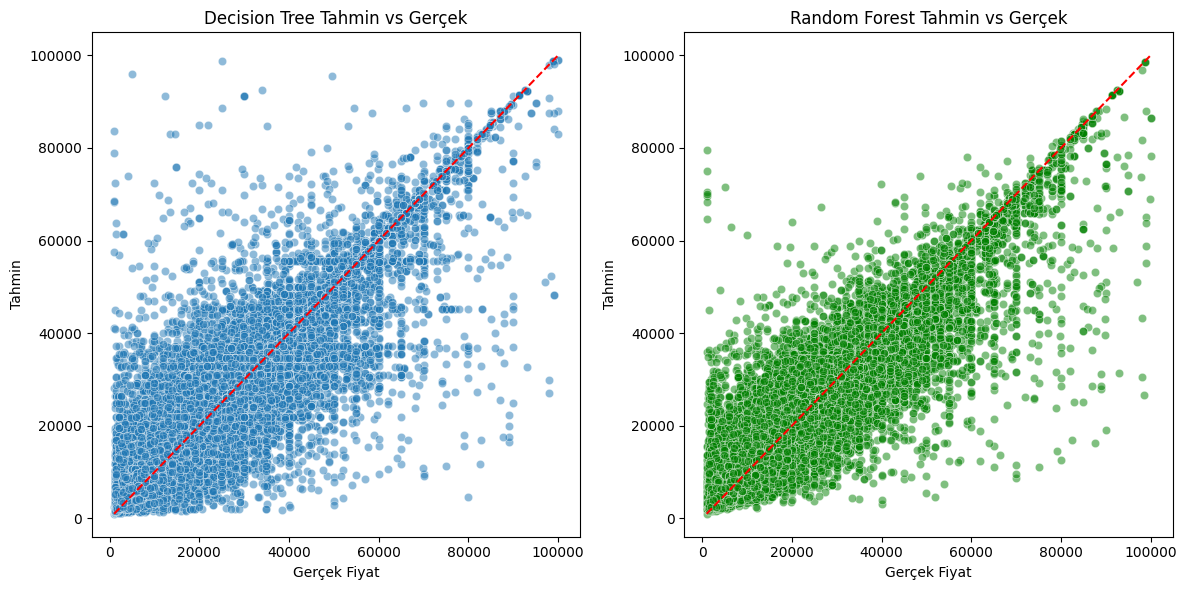

In [2]:
# 1-) Kütüphaneleri Yükle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 2-)Veri Yükleme
df = pd.read_csv("/kaggle/input/craigslist-carstrucks-data/vehicles.csv")
selected_cols = ['price', 'year', 'manufacturer', 'model', 'condition', 
                 'odometer', 'fuel', 'transmission', 'type', 'cylinders', 
                 'drive', 'paint_color', 'title_status']
df_copy = df[selected_cols].copy()

# 3-) Aykırı Fiyatları Temizle
df_copy = df_copy[(df_copy["price"] > 1000) & (df_copy["price"] < 100000)]

# 4-) Eksik Verileri Doldur
categorical_cols = ['manufacturer', 'model', 'condition', 'fuel', 'transmission', 
                    'type', 'cylinders', 'drive', 'paint_color', 'title_status']

for col in categorical_cols:
    mode_value = df_copy[col].mode()
    if not mode_value.empty:
        df_copy[col] = df_copy[col].fillna(mode_value[0])
    else:
        df_copy[col] = df_copy[col].fillna('missing')

df_copy["year"] = df_copy["year"].fillna(df_copy["year"].median())
df_copy["odometer"] = df_copy["odometer"].fillna(df_copy["odometer"].median())

# 5-) Feature Engineering & Encoding

# Model için frekans encoding
freq = df_copy['model'].value_counts() / len(df_copy)
df_copy['model_freq_enc'] = df_copy['model'].map(freq)
df_copy.drop(columns=['model'], inplace=True)

# Manufacturer - One Hot
df_copy = pd.get_dummies(df_copy, columns=['manufacturer'], drop_first=True)

# Condition - Ordinal (NaN'ları -1 olarak kodla)
condition_order = ['salvage','poor', 'fair', 'good', 'excellent', 'like new', 'new']
ordinal_enc = OrdinalEncoder(categories=[condition_order], dtype=int,
                             handle_unknown='use_encoded_value', unknown_value=-1)
df_copy['condition'] = ordinal_enc.fit_transform(df_copy[['condition']])

# Fuel, Transmission, Type - One Hot
df_copy = pd.get_dummies(df_copy, columns=['fuel', 'transmission', 'type'], drop_first=True)

# Title status - Binary
df_copy['title_status'] = df_copy['title_status'].apply(lambda x: 1 if x=='clean' else 0)

# Cylinders - Sayısal
df_copy['cylinders'] = df_copy['cylinders'].astype(str).str.extract('(\d+)').astype(float)
df_copy['cylinders'] = df_copy['cylinders'].fillna(df_copy['cylinders'].median())

# Drive - One Hot
df_copy = pd.get_dummies(df_copy, columns=['drive'], drop_first=True)

# Paint color - Drop (isteğe bağlı)
df_copy.drop(columns=['paint_color'], inplace=True)

# 6-) Girdi ve Hedef Değişkeni Ayır
X = df_copy.drop("price", axis=1)
y = df_copy["price"]



# 7-)Train-Test Ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8-) NaN Kontrol
print("Model girişinde NaN var mı?:", X_train.isnull().sum().sum())
print("Model hedefinde NaN var mı?:", y_train.isnull().sum())

# 9-)Decision Tree - GridSearch (Optimizasyonlu Parametreler)
dtree = DecisionTreeRegressor(random_state=42)
dt_params = {
    "max_depth": [10, 20],               # Azaltıldı
    "min_samples_split": [2, 5],         # Azaltıldı
    "min_samples_leaf": [1, 2]           # Azaltıldı
}

grid_dt = GridSearchCV(dtree, dt_params, cv=3, scoring="neg_mean_squared_error", n_jobs=1)
grid_dt.fit(X_train, y_train)
best_dtree = grid_dt.best_estimator_

# 10. Random Forest - GridSearch (Optimizasyonlu Parametreler)
rf = RandomForestRegressor(random_state=42, n_jobs=1)
rf_params = {
    "n_estimators": [50],               # Küçültüldü
    "max_depth": [10, 20],             # Azaltıldı
    "min_samples_split": [2],          # Azaltıldı
    "min_samples_leaf": [1]            # Azaltıldı
}

grid_rf = GridSearchCV(rf, rf_params, cv=3, scoring="neg_mean_squared_error", n_jobs=1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

# 11. Değerlendirme Fonksiyonu
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"\n{name} Performansı:")
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("MAE:", mae)
    return y_pred

# 12. Modelleri Değerlendir
y_pred_dt = evaluate_model("Decision Tree", best_dtree, X_test, y_test)
y_pred_rf = evaluate_model("Random Forest", best_rf, X_test, y_test)

# 13. Tahmin Karşılaştırma Grafiği
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred_dt, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("Decision Tree Tahmin vs Gerçek")
plt.xlabel("Gerçek Fiyat")
plt.ylabel("Tahmin")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("Random Forest Tahmin vs Gerçek")
plt.xlabel("Gerçek Fiyat")
plt.ylabel("Tahmin")

plt.tight_layout()
plt.show()


In [3]:
print(df_copy.shape)
df_copy.head() 

(378659, 68)


,price,year,condition,odometer,cylinders,title_status,model_freq_enc,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,...,type_mini-van,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon,drive_fwd,drive_rwd
0,6000,2013.0,3,87634.0,6.0,1,0.029525,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,11900,2013.0,3,87634.0,6.0,1,0.029525,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,21000,2013.0,3,87634.0,6.0,1,0.029525,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,1500,2013.0,3,87634.0,6.0,1,0.029525,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,4900,2013.0,3,87634.0,6.0,1,0.029525,False,False,False,...,False,False,False,False,True,False,False,False,False,False


Veri Seti Genel Bilgileri:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         426880 non-null  int64  
 1   year          425675 non-null  float64
 2   manufacturer  409234 non-null  object 
 3   model         421603 non-null  object 
 4   condition     252776 non-null  object 
 5   odometer      422480 non-null  float64
 6   fuel          423867 non-null  object 
 7   transmission  424324 non-null  object 
 8   type          334022 non-null  object 
 9   cylinders     249202 non-null  object 
 10  drive         296313 non-null  object 
 11  paint_color   296677 non-null  object 
 12  title_status  418638 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 42.3+ MB
None

Veri Setindeki İlk 5 Satır:
   price  year manufacturer model condition  odometer fuel transmission type  \
0   6000   NaN          

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


count    4.268800e+05
mean     7.519903e+04
std      1.218228e+07
min      0.000000e+00
25%      5.900000e+03
50%      1.395000e+04
75%      2.648575e+04
max      3.736929e+09
Name: price, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


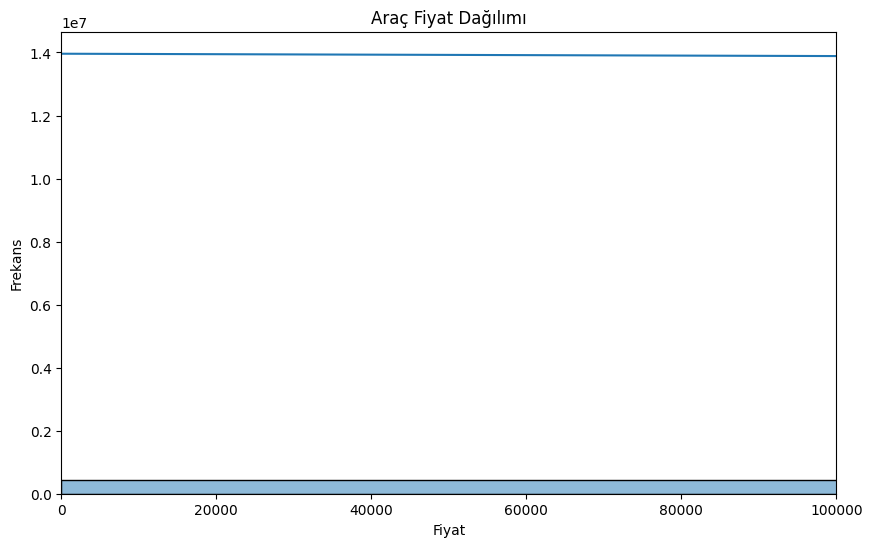

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


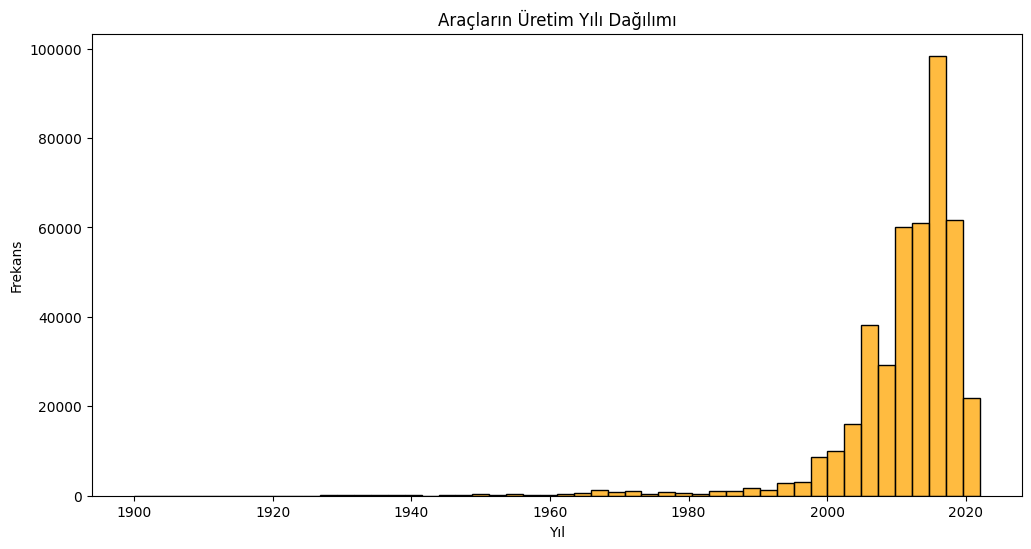

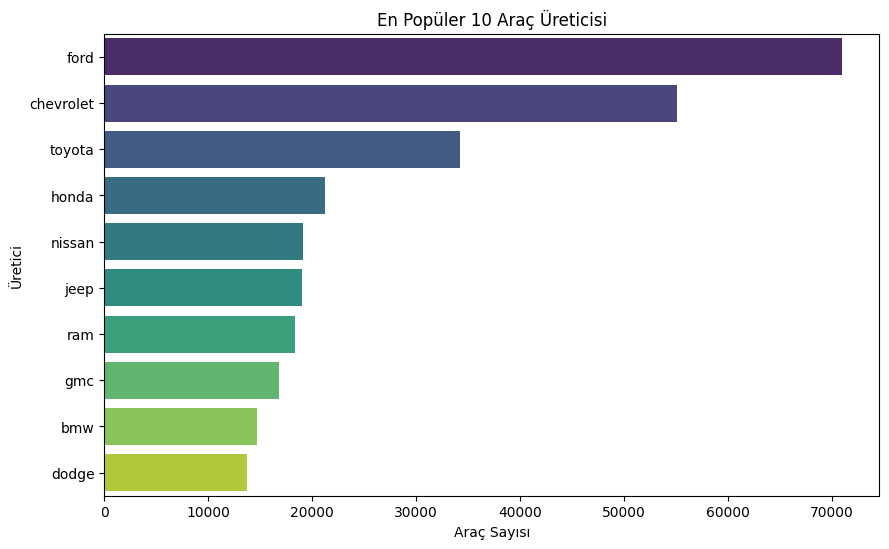

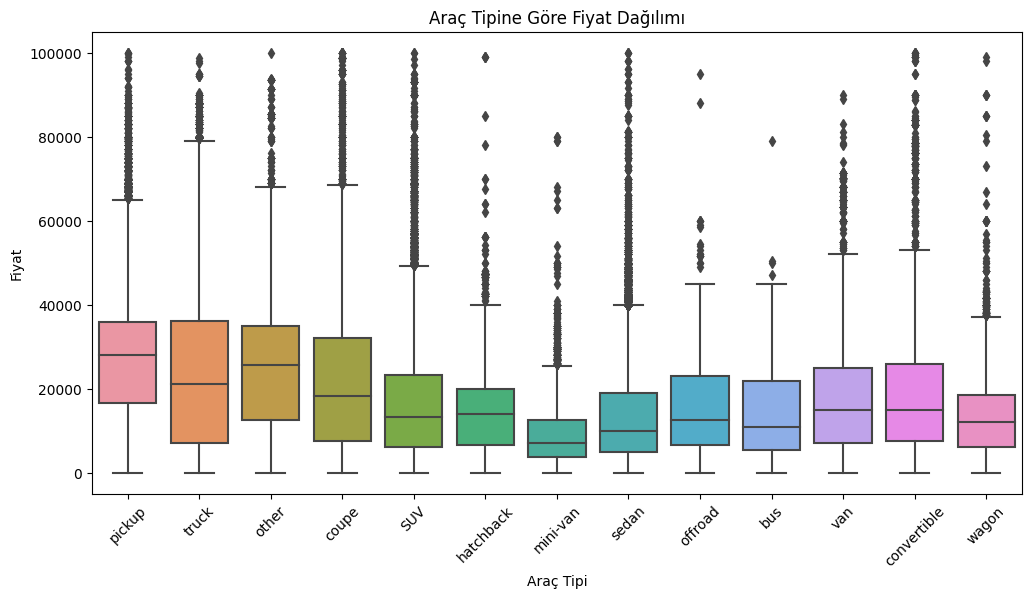

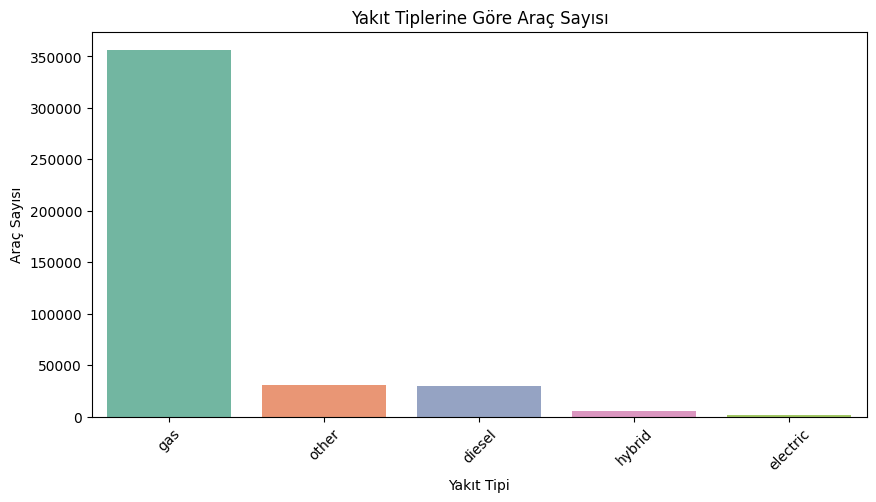

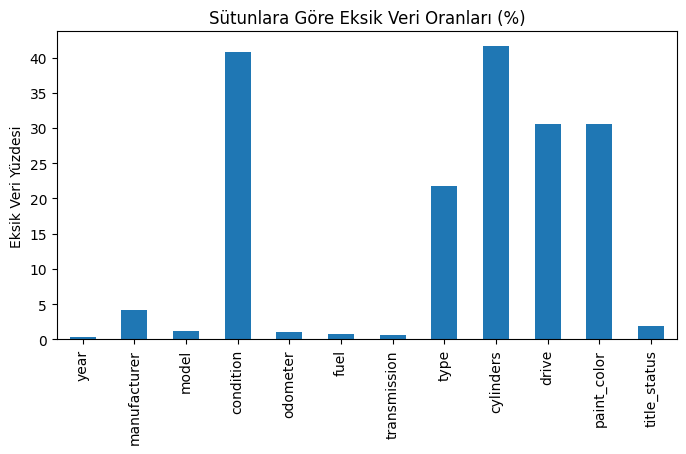

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Veri setini yükle
df = pd.read_csv("/kaggle/input/craigslist-carstrucks-data/vehicles.csv")

# Seçilen sütunlar
selected_cols = ['price', 'year', 'manufacturer', 'model', 'condition', 
                 'odometer', 'fuel', 'transmission', 'type', 'cylinders', 
                 'drive', 'paint_color', 'title_status']

df = df[selected_cols]

# 1- Genel Bilgiler
print("Veri Seti Genel Bilgileri:")
print(df.info())

print("\nVeri Setindeki İlk 5 Satır:")
print(df.head())

print("\nEksik Değerlerin Sayısı:")
print(df.isnull().sum())

print("\nFiyat sütunundaki temel istatistikler:")
print(df['price'].describe())

# 2- Fiyat dağılımı histogramı
plt.figure(figsize=(10,6))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Araç Fiyat Dağılımı')
plt.xlabel('Fiyat')
plt.ylabel('Frekans')
plt.xlim(0, 100000)  # Aykırı fiyatlar yüzünden sınırlandırıldı
plt.show()

# 3- Araç üretim yıllarının dağılımı
plt.figure(figsize=(12,6))
sns.histplot(df['year'].dropna(), bins=50, kde=False, color='orange')
plt.title('Araçların Üretim Yılı Dağılımı')
plt.xlabel('Yıl')
plt.ylabel('Frekans')
plt.show()

# 4- En sık görülen 10 üretici
top_manufacturers = df['manufacturer'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_manufacturers.values, y=top_manufacturers.index, palette='viridis')
plt.title('En Popüler 10 Araç Üreticisi')
plt.xlabel('Araç Sayısı')
plt.ylabel('Üretici')
plt.show()

# 5- Araç tiplerine göre fiyatların kutu grafiği
plt.figure(figsize=(12,6))
sns.boxplot(x='type', y='price', data=df[df['price'] < 100000])
plt.title('Araç Tipine Göre Fiyat Dağılımı')
plt.xticks(rotation=45)
plt.xlabel('Araç Tipi')
plt.ylabel('Fiyat')
plt.show()

# 6- Yakıt tipine göre araç sayıları
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='fuel', order=df['fuel'].value_counts().index, palette='Set2')
plt.title('Yakıt Tiplerine Göre Araç Sayısı')
plt.xlabel('Yakıt Tipi')
plt.ylabel('Araç Sayısı')
plt.xticks(rotation=45)
plt.show()

# 7- Eksik veri oranlarını görselleştirme
missing_percent = df.isnull().mean() * 100
missing_percent = missing_percent[missing_percent > 0]

plt.figure(figsize=(8,4))
missing_percent.plot(kind='bar')
plt.title('Sütunlara Göre Eksik Veri Oranları (%)')
plt.ylabel('Eksik Veri Yüzdesi')
plt.show()